# Using SVM Classifier to generate a summary of a text

### Sentence Features:

1. How many keywords does it contain? (needs to be scaled down by the length of the sentence)
2. Position of sentence
3. Does it mention location
4. Score from TFIDF Summarizer

## Calculate features

In [41]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [42]:
df = pd.read_json('SummaRuNNer/data/processed/test_data.json', lines=True)

In [43]:
df.describe()

id
count  41.000000  
mean   3527.268293
std    1446.670540
min    2068.000000
25%    2222.000000
50%    3330.000000
75%    4316.000000
max    6807.000000

### 1. Keywords Feature

In [44]:
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(copy=True, feature_range=(0, 1))

def extract_keywords_feature(entry):
    keywords = entry.keywords.split(', ')
    keywords = set(keywords)
    sentences_feature = list()
    sentences = entry.doc.split('\n')
    for sentence in sentences:
        words = word_tokenize(sentence)
        matching_keywords = list(set(words) & set(keywords)) # TODO: use word2vec and cosine sim
        sentences_feature.append(len(matching_keywords) / len(set(keywords)) / len(words)) # scale score by sentence length
    #return sentences_feature
    return scaler.fit_transform(np.array(sentences_feature).reshape(-1, 1))

In [45]:
df['keywords_feature'] = df.apply(lambda x: extract_keywords_feature(x), axis=1)

### 2. Sentence Position Feature

Scale data in range `[-1, 1]` and then compute the value of each sentence position to be `1 - |position|` so that the most weight is added to sentences in the middle of the text.

In [46]:
scaler = MinMaxScaler(copy=True, feature_range=(-1, 1))
def extract_position_feature(entry):
    sentences = entry.doc.split('\n')
    if len(sentences) <= 1:
        return [0]
    sentences_feature = np.array([(index+1.0) for index, _ in enumerate(sentences)]).reshape(-1,1)
    return [1 - abs(feature.tolist()[0]) for feature in scaler.fit_transform(sentences_feature)]

In [47]:
df['position_feature'] = df.apply(lambda x: extract_position_feature(x), axis=1)

### 3. Location Feature

In [48]:
def extract_location_feature(entry):
    sentences_feature = list()
    sentences = entry.doc.split('\n')
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        if entry.location.lower() in words:
            sentences_feature.append(1.0)
        else:
            sentences_feature.append(0.0)
    return sentences_feature

In [49]:
df['location_feature'] = df.apply(lambda x: extract_location_feature(x), axis=1)

### 4. TFIDF Score Feature

In [50]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
def extract_sent_score(doc):
    summary, keywords, sent_info = summarize(doc)
    sent_scores = [sent['sent_score'] for sent in sent_info]
    return scaler.fit_transform(np.array(sent_scores).reshape(-1,1))

In [51]:
from tfidf_summarize import summarize 

In [52]:
df['tfidf_feature'] = df.apply(lambda x: extract_sent_score(x.doc), axis=1)

#### Combine all features in a single array

In [53]:
def combine_features_in_array(entry):
    features = list()
    for index, _ in enumerate(entry.doc.split('\n')):
        keywords = entry.keywords_feature[index][0]
        position = entry.position_feature[index]
        location = entry.location_feature[index]
        tfidf = entry.tfidf_feature[index][0]
        features.append([keywords, position, location, tfidf])
    return features

In [54]:
df['features'] = df.apply(lambda x: combine_features_in_array(x), axis=1)

In [55]:
df = df.rename(index=str, columns={"features": "sent_features"})


In [56]:
with open('SummaRuNNer/data/processed/test_data_features.json', 'w') as f:
    f.write(df[['id', 'doc', 'summaries', 'keywords', 'labels', 'sent_features']].to_json(orient='records', lines=True))

In [403]:
text_features = df.features.tolist()
sentence_features = [sent for text in text_features for sent in text]
len(sentence_features)

2300

#### Combine all labels in a single array

In [404]:
df['labels'] = df.apply(lambda x: x.labels.split('\n'), axis=1)

In [405]:
sentence_labels = [int(label) for text in df.labels.values for label in text]
len(sentence_labels)

2300

### Visualize features data

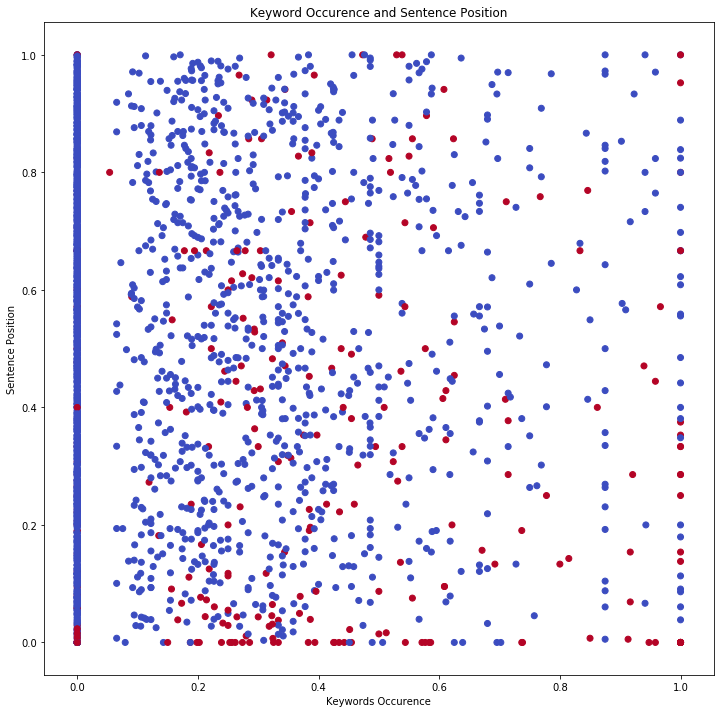

In [373]:
%matplotlib inline
import matplotlib.pyplot as plt
def visualize_sentence_data():
    data = np.array(sentence_features)
    X = data[:, :2]  # we only take the first two features.
    y = np.array(sentence_labels)
    plt.figure(figsize=(12,12))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Keywords Occurence')
    plt.ylabel('Sentence Position')
    plt.title('Keyword Occurence and Sentence Position')
    plt.show()
 
visualize_sentence_data()

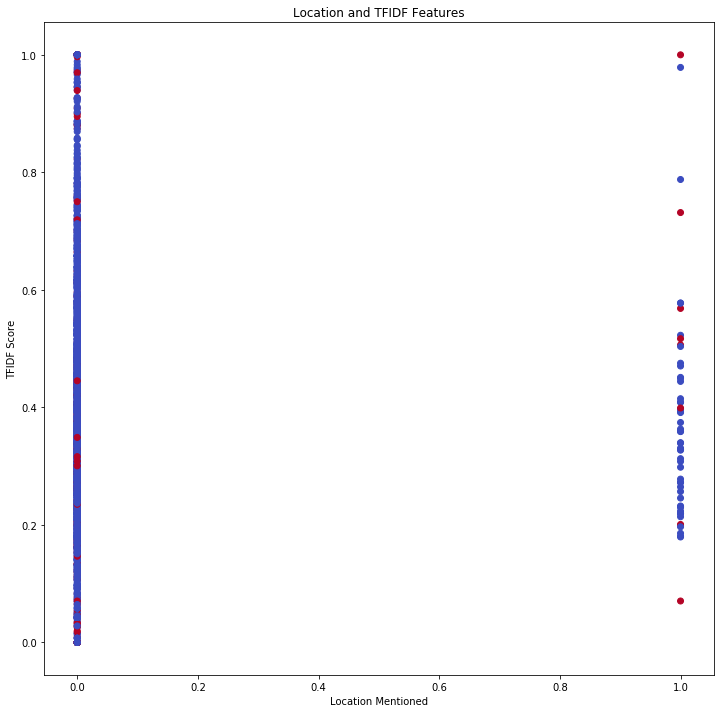

In [374]:
def visualize_sentence_data():
    data = np.array(sentence_features)
    X = data[:, 2:]  # we only take last two features.
    y = np.array(sentence_labels)
    plt.figure(figsize=(12,12))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Location Mentioned')
    plt.ylabel('TFIDF Score')
    plt.title('Location and TFIDF Features')
    plt.show()
 
visualize_sentence_data()

## Create SVM

In [353]:
from sklearn import svm

In [355]:
X = np.array(sentence_features)
y = np.array(sentence_labels)
C = 1.0  # SVM regularization parameter

# SVC with linear kernel
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# LinearSVC (linear kernel)
lin_svc = svm.LinearSVC(C=C).fit(X, y)
# SVC with RBF kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
# SVC with polynomial (degree 3) kernel
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Use the SVM to generate summaries

In [425]:
def generate_svm_summary(entry):
    predicted_sents = lin_svc.predict(entry.features)
    summary = list()
    for index, sent in enumerate(entry.doc.split('\n')):
        if predicted_sents[index] == 1:
            summary.append(sent)
    if len(summary) == 0:
        return None
    return ' '.join(summary)
    
df['svm_summary'] = df.apply(lambda x: generate_svm_summary(x), axis=1)

In [426]:
df_svm = df[['doc', 'summaries','svm_summary']]


In [428]:
df_svm[pd.notnull(df_svm['svm_summary'])]

doc  \
7   ukactive Contact Us Quick links Home About Us if gte IE 7 Liverpool John Moores University Visit Website src httpresearchinstitute.ukactive.comimg2.aspx?img3VTP1ZFUBFLiverpoolJohnMooresUniversityfrom2013.pngw116h60 width 116 height 60 Home About Us Services Research Hub Projects Contact Us 2018 ukactive ukactive is a company registered in England with company number 2589238.\nRegistered in England with company number 2589238.\nPolicy Briefings ukactives Public Affairs Team has a dedicated political monitoring function to ensure we are kept abreast of all relevant policy developments and able to inform Strategic Partners when developments occur that may impact their strategic or operational landscape.\nDedicated Account Manager You will have an assigned Account Manager within the team.\nThey will maintain regular contact with you which will include running an initial planning session at the outset of your contract and then continuing to discuss upcoming events and opportunities regarding your work plan and will be available for you to call at any stage throughout the duration of your agreement.\nDriving the Physical Activity Forward Government ukactives dedicated Public Affairs Department campaigns to lawmakers and opinionformers on the issues that impact on our members ability to operate and lobbies to ensure that the sector has a leading role in influencing programmes being established to address the inactivity crisis in the UK.\nMarket landscaping consultancy ukactive can support you to identify potential partnership opportunities in agreed priority areas.\nThese could include structured engagement with activity providers healthcare professionals and commercial brands.\nWe are able to provide unique insight into the context within which the sector operates including the best way to launch pilot and grow your productsservices and evaluate success.\nThought Leadership Opportunities ukactive has a highly experienced marketing and communications team who can provide guidance and planning to assist its Strategic Partners with their external communications.\nFor example this can involve developing a comprehensive communications strategy or bespoke onrequest support such as drafting press releases identifying key media contacts and providing social media consultancy.\nResearch Insight Services The ukactive Research Institute can conduct bespoke projects for ukactives Strategic Partners measuring the impact and positive outcomes related to their work in physical activity promotion.\nIt has also developed a specialist business analytics consultancy offer using business and member data to predict likely trends in membership demographics member behaviour and profitability.\nThis powerful service can be used to manage the risk associated with large business decisions and provide a degree of insight into how an organisation can maximise its profit.\nEvents Sponsorship and Assistance Strategic partners have the opportunity to sponsor headline ukactive events including the annual FLAME Conference the ukactive National Summit and ukactives exclusive quarterly Strategic Partner Events.\nSimilarly when a Strategic Partner is looking to organise its own event they have access to the support and expertise offered by the ukactive Events Team.\nRegistered in England with company number 2589238.\nOver the last 20 years ukactive has worked to develop sustainable longterm partnerships with government departments major brands National Governing Bodies of Sport charities and many other organisations with an interest in getting more people more active more often and improving the health and wellbeing of the nation.\nWill Smithard Strategic Projects Director Asda Active 07052018 vertcenter workitem span4 Park Lives 07052018 vertcenter workitem span4 10 Minute Shake up!\nRegistered in England with company number 2589238.\nWillmott Dixon is one of the UKs most prolific constructors of leisure facilities in the past 10 years the company has buil

In [430]:
df_svm.describe()

doc  \
count   41                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
unique  41                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [429]:
with open('SummaRuNNer/data/processed/svm_summaries.json', 'w') as f:
    f.write(df_svm.to_json(orient='records', lines=True))

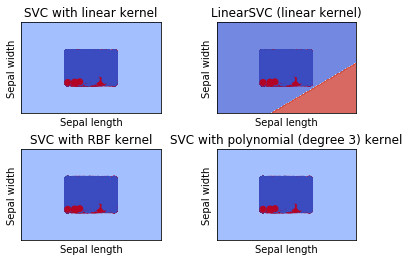

In [161]:
h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# title for the plots
titles = ['SVC with linear kernel','LinearSVC (linear kernel)','SVC with RBF kernel','SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()